# Turning Raw Spotify Track Data into a Modeling Dataset  
*Integration, cleaning, and feature preparation for popularity prediction*

## 1. Introduction
Music streaming has become an ordinary part of daily life, and platforms like Spotify play a central role in how listeners discover and engage with music. The listening experience today is far more personalized than it was in the past, shaped by recommendations that adapt to individual tastes, habits, and patterns over time. At the core of this transformation is data.

While listener data is not available in this project, Spotify provides extensive information at the track and artist level. This includes audio features that describe how a song sounds, metadata that situates it in time and context, and aggregate measures of engagement such as track popularity. Together, these features offer a partial but meaningful view into how songs are represented and surfaced on the platform.

This notebook focuses on preparing and integrating Spotify track and artist datasets into a clean, modeling ready format. The resulting dataset serves as the foundation for subsequent exploratory analysis and predictive modeling of song popularity.

## 2. Libraries and Setup
This section imports the core utilities used throughout the notebook and sets display options for easier inspection. The libraries cover list parsing, data manipulation, and lightweight visualization used for quick sanity checks during wrangling.

In [1]:
# Core utilities
# Purpose: Enables postponed evaluation of type annotations for cleaner type hints and forward compatibility.
from __future__ import annotations


# Abstract Syntax 
# Purpose: Used to safely convert list-like strings in the raw Spotify data into actual Python lists.
import ast


# Core data stack
# Purpose: arrays + dataframes
import pandas as pd
import numpy as np


# Visualization
# Purpose: create visualizations
import matplotlib.pyplot as plt


# Text processing
# Purpose: Text normalization
import re


# Display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

## 3. Data Wrangling and Preparation

### 3.1 Read Files
The data preparation process begins by loading the raw Spotify track and artist datasets. These datasets are later combined, transformed, and feature engineered to produce an enriched, track-level dataset that is saved as a parquet file for downstream exploratory analysis and modeling.

In [2]:
tracks = pd.read_csv("tracks.csv")
artists = pd.read_csv("artists.csv")

### 3.2 Data Cleaning and Standardization

#### 3.2.1 Data Type Standardization
This section focuses on reviewing and standardizing data types across the track and artist datasets. Ensuring that variables are stored using appropriate data types is a key step in data preparation, as it supports accurate transformations, comparisons, and downstream analysis. An initial inspection of each dataset is performed to confirm that columns align with their expected representations.

In [3]:
print("Tracks Original Shape:", tracks.shape)
print("Artists Original Shape:", artists.shape)

Tracks Original Shape: (586672, 20)
Artists Original Shape: (1162095, 5)


In [4]:
tracks.info()

<class 'pandas.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  str    
 1   name              586601 non-null  str    
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  str    
 6   id_artists        586672 non-null  str    
 7   release_date      586672 non-null  str    
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          586672 non-nu

In [5]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [6]:
artists.info()

<class 'pandas.DataFrame'>
RangeIndex: 1162095 entries, 0 to 1162094
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1162095 non-null  str    
 1   followers   1162084 non-null  float64
 2   genres      1162095 non-null  str    
 3   name        1162092 non-null  str    
 4   popularity  1162095 non-null  int64  
dtypes: float64(1), int64(1), str(3)
memory usage: 93.2 MB


In [7]:
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [8]:
dtype_specifications = {
    "float": [
        "danceability",
        "energy",
        "loudness",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "followers"
    ],
    "int": [
        "popularity",
        "duration_ms",
        "key",
        "mode",
        "time_signature"
    ],
    "string": [
        "id",
        "name",
        "release_date" # Kept release_date as string because some entries are incomplete
    ]
}

In [9]:
def standardize_dtypes(df, spec, errors="coerce"):
    """
    Standardize dataframe dtypes based on a spec dict.
    - Preserves missing values using pandas nullable dtypes where appropriate.
    - Ignores columns not present in the dataframe.
    """
    df = df.copy()

    # dates
    for col in spec.get("datetime", []):
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors=errors)

    # floats
    for col in spec.get("float", []):
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # integers
    for col in spec.get("int", []):
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    # strings
    for col in spec.get("string", []):
        if col in df.columns:
            df[col] = df[col].astype("string")

    # categories
    for col in spec.get("category", []):
        if col in df.columns:
            df[col] = df[col].astype("category")

    return df

In [10]:
artists = standardize_dtypes(artists, dtype_specifications)
tracks = standardize_dtypes(tracks, dtype_specifications)

In [11]:
# Extract release year for modeling
tracks["release_year"] = tracks["release_date"].str.slice(0, 4).astype("Int64")

In [12]:
print(artists.dtypes.sort_index())
print("-----" * 7)
print(tracks.dtypes.sort_index())

followers     float64
genres            str
id             string
name           string
popularity      Int64
dtype: object
-----------------------------------
acousticness        float64
artists                 str
danceability        float64
duration_ms           Int64
energy              float64
explicit              int64
id                   string
id_artists              str
instrumentalness    float64
key                   Int64
liveness            float64
loudness            float64
mode                  Int64
name                 string
popularity            Int64
release_date         string
release_year          Int64
speechiness         float64
tempo               float64
time_signature        Int64
valence             float64
dtype: object


Data types were standardized across numeric and string fields, and `release_year` was extracted from `release_date` for downstream feature engineering and modeling.

#### 3.2.2 Rename Columns
This section standardizes column names across datasets to reduce ambiguity and improve clarity prior to merging. Several fields share common names across tables, such as identifiers and popularity metrics, which can lead to confusion during joins and downstream analysis if left unchanged. Renaming these columns early helps make dataset roles explicit and ensures that merged features remain interpretable.

In [13]:
tracks.rename(columns={
    "id": "track_id",
    "name": "track_name",
    "popularity": "track_popularity",
    "id_artists": "artist_id_list"
}, 
              inplace = True)

artists.rename(columns={
    "id": "artist_id",
    "name": "artist_name",
    "popularity": "artist_popularity"
}, 
              inplace = True)

After renaming overlapping columns to clearly distinguish track-level and artist-level attributes, the datasets are better structured for subsequent merges and analysis.

#### 3.2.3 Normalizing and Parsing List-Like Fields
Some fields in the raw data represent multi-value relationships. Before expanding the data into a track–artist format and performing merges, these fields are parsed and normalized so list-like values become consistent Python lists.

In [14]:
def parse_list_field(x, mode="generic"):
    """
    Parse list-like values and clean items based on mode.
    mode: "artists" | "artist_id" | "genres" | "generic"
    """
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []

    if isinstance(x, np.ndarray):
        x = x.tolist()

    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                x = ast.literal_eval(s)
            except Exception:
                x = [s] if s else []
        else:
            x = [s] if s else []

    if not isinstance(x, list):
        x = [x]

    cleaned = []
    for item in x:
        if item is None:
            continue
        s = str(item).strip()

        if mode == "genres":
            s = s.lower()
        elif mode == "artist_id":
            s = s.strip("'\"")
        elif mode == "artists":
            pass

        if s:
            cleaned.append(s)

    return cleaned

In [15]:
tracks["artists"] = tracks["artists"].apply(lambda x: parse_list_field(x, "artists"))
tracks["artist_id_list"] = tracks["artist_id_list"].apply(lambda x: parse_list_field(x, "artist_id"))
artists["genres"] = artists["genres"].apply(lambda x: parse_list_field(x, "genres"))

After normalization, list-like fields were converted to consistent Python lists and are ready for track-artist expansion.

#### 3.2.4 Duplicate Handling
Duplicate checks are performed after list parsing, with list-like fields temporarily converted to tuples where needed to support hash-based comparison. This enables reliable exact, metadata-level, and near-duplicate detection before downstream integration.

##### Raw ID Uniqueness Check
We first verify whether `track_id` and `artist_id` are duplicated. This confirms whether the source data has primary-key violations before applying more detailed duplicate logic.

In [16]:
is_duplicate_track_id = tracks.duplicated(subset="track_id")
print(is_duplicate_track_id.sum())

is_duplicate_artist_id = artists.duplicated(subset="artist_id")
print(is_duplicate_artist_id.sum())

0
0


Raw identifier checks showed that `track_id` and `artist_id` are unique in their respective source tables. This indicates no primary-key violations at ingestion, so no rows were dropped at this stage.

##### Exact Row Duplicates (Ignoring `track_id`)
This check finds rows that are identical across all track attributes except `track_id`. It detects duplicate records that were assigned different IDs and removes redundant copies.

In [17]:
tmp = tracks.copy()

for c in ["artists", "artist_id_list"]:
    if c in tmp.columns:
        tmp[c] = tmp[c].apply(lambda v: tuple(v) if isinstance(v, list) else v)

compare_cols = [c for c in tmp.columns if c != "track_id"]

dupe_groups = (
    tmp.groupby(compare_cols, dropna=False)
       .agg(n_rows=("track_id", "size"), n_track_ids=("track_id", "nunique"))
       .reset_index()
       .query("n_track_ids > 1")
)

print("Tracks-only exact duplicate groups:", len(dupe_groups))
print("Rows in these groups:", int(dupe_groups["n_rows"].sum()))

dupe_rows = tmp.merge(dupe_groups[compare_cols], on=compare_cols, how="inner")
display(
    dupe_rows[["track_name", "track_id", "artists", "release_date", "track_popularity"]]
    .sort_values(["track_name", "release_date"])
    .head(10)
)

Tracks-only exact duplicate groups: 1145
Rows in these groups: 2598


,track_name,track_id,artists,release_date,track_popularity
649,(Theme From) The Monkees - Original Stereo Ver...,4zM6xmUvW8cuyMdvwnCtH3,"(The Monkees,)",1966-10-10,41
1799,(Theme From) The Monkees - Original Stereo Ver...,1vO6HIxVjwj25N1r2KCSEF,"(The Monkees,)",1966-10-10,41
686,10 Years Report - 2016,0Rr08tqYnsgA29VDtLC2eJ,"(Dishonour,)",2016-11-02,0
2566,10 Years Report - 2016,4sxa9gdyu2WUkfO9FPdSY6,"(Dishonour,)",2016-11-02,0
714,100 Years Later (2012 Version),34w3JaZkzc8k0RsY0kCfWV,"(Big Mouth King,)",2012-09-15,0
2569,100 Years Later (2012 Version),6boPLs1No4X8oOLgY9hyGr,"(Big Mouth King,)",2012-09-15,0
1015,1000 Years - BARE Remix,5V6QceiCLkgHTWahWhn05u,"(Gina Star,)",2013-12-08,0
1232,1000 Years - BARE Remix,7FLgZmBumEpvPqEcSamXNq,"(Gina Star,)",2013-12-08,0
724,15 Million Light Years Away - 2013 Reunion,0VUREyxgvOFyvuylRYWkPz,"(Black Oak Arkansas,)",2013-10-15,0
725,15 Million Light Years Away - 2013 Reunion,0qvLhoq4YY4NWv1fBldaLV,"(Black Oak Arkansas,)",2013-10-15,0


In [18]:
# Keep one row per exact-duplicate signature (ignoring track_id)
before = len(tmp)
tmp_dedup = tmp.drop_duplicates(subset=compare_cols, keep="first").copy()
after = len(tmp_dedup)

for c in ["artists", "artist_id_list"]:
    if c in tmp_dedup.columns:
        tmp_dedup[c] = tmp_dedup[c].apply(lambda v: list(v) if isinstance(v, tuple) else v)

print(f"Rows before: {before:,}")
print(f"Rows after : {after:,}")
print(f"Removed    : {before - after:,}")

tracks = tmp_dedup

Rows before: 586,672
Rows after : 585,219
Removed    : 1,453


In [19]:
check = tracks.copy()
for c in ["artists", "artist_id_list"]:
    if c in check.columns:
        check[c] = check[c].apply(lambda v: tuple(v) if isinstance(v, list) else v)

key_cols = [c for c in check.columns if c != "track_id"]

remaining = (
    check.groupby(key_cols, dropna=False)["track_id"]
         .nunique()
         .gt(1)
         .sum()
)

print("Remaining exact duplicate groups (except track_id):", int(remaining))

Remaining exact duplicate groups (except track_id): 0


Exact duplicate signatures were found when comparing all track fields except `track_id`. These rows represent redundant records rather than distinct songs, so duplicate copies were dropped to keep one canonical row per identical metadata profile.

##### Conflicting Popularity Across Duplicate Metadata
Here we isolate groups where metadata is the same but both `track_id` and `track_popularity` differ. This flags likely duplicate representations with inconsistent engagement values that need reconciliation.

In [20]:
check_2 = tracks.copy()

for c in ["artists", "artist_id_list"]:
    if c in check_2.columns:
        check_2[c] = check_2[c].apply(lambda v: tuple(v) if isinstance(v, list) else v)

# Duplicate key excludes track_id + track_popularity
key_cols_2 = [c for c in check_2.columns if c not in ["track_id", "track_popularity"]]

pop_conflict_2 = (
    check_2.groupby(key_cols_2, dropna=False)
           .agg(
               n_rows=("track_id", "size"),
               n_track_ids=("track_id", "nunique"),
               n_pop=("track_popularity", "nunique"),
           )
           .reset_index()
           .query("n_track_ids > 1 and n_pop > 1")
           .copy()
)

print("Groups with different track_id and different track_popularity:", len(pop_conflict_2))
print("Rows in those groups:", int(pop_conflict_2["n_rows"].sum()))

rows_2 = check_2.merge(pop_conflict_2[key_cols_2], on=key_cols_2, how="inner")
display(
    rows_2[["track_name", "track_id", "artists", "release_date", "track_popularity"]]
    .sort_values(["track_name", "release_date", "track_popularity"], ascending=[True, True, False])
    .head(10)
)

Groups with different track_id and different track_popularity: 5708
Rows in those groups: 12371


,track_name,track_id,artists,release_date,track_popularity
3998,"""40"" - Remastered 2008",3vMmwsAiLDCfyc1jl76lQE,"(U2,)",1983-02-28,38
3997,"""40"" - Remastered 2008",6DdWA7D1o5TU2kXWyCLcch,"(U2,)",1983-02-28,37
2226,#1,35NyjYJFaJxqbUF2y0jWl1,"(Aphex Twin,)",1994-03-07,48
11989,#1,35D08mRCscrNHuQm2rUUPw,"(Aphex Twin,)",1994-03-07,17
10674,#1 Crush - Nellee Hooper Mix,08L1WAtYQnsFBoZ3MEBkYV,"(Garbage, Nellee Hooper)",1995,47
7590,#1 Crush - Nellee Hooper Mix,6IOMonIqYymqCwQSKKyUJQ,"(Garbage, Nellee Hooper)",1995,35
2224,#20,5IExVHUiRccCWyJ4imu9qD,"(Aphex Twin,)",1994-03-07,48
11990,#20,2vtyLVpmCyW63wayDIldYI,"(Aphex Twin,)",1994-03-07,16
2211,#3,2Bc4llhjJBW77I552RgA3L,"(Aphex Twin,)",1994-03-07,59
11985,#3,2SqT2ztd3x80so3u3FPRHD,"(Aphex Twin,)",1994-03-07,24


##### Collapse Duplicate Metadata Rows
After identifying metadata-level duplicates, we collapse them into one row per signature. Keeping one `track_id` and using median `track_popularity` preserves a stable record while reducing noise from repeated entries.

In [21]:
collapse_df = tracks.copy()

for c in ["artists", "artist_id_list"]:
    if c in collapse_df.columns:
        collapse_df[c] = collapse_df[c].apply(lambda v: tuple(v) if isinstance(v, list) else v)

# Grouping key: everything except track_id + track_popularity
group_cols = [c for c in collapse_df.columns if c not in ["track_id", "track_popularity"]]

collapsed_tracks = (
    collapse_df.groupby(group_cols, dropna=False, as_index=False)
               .agg(
                   track_id=("track_id", "first"),
                   track_popularity=("track_popularity", "median"),
               )
)

for c in ["artists", "artist_id_list"]:
    if c in collapsed_tracks.columns:
        collapsed_tracks[c] = collapsed_tracks[c].apply(lambda v: list(v) if isinstance(v, tuple) else v)

print("Rows before collapse:", len(tracks))
print("Rows after collapse :", len(collapsed_tracks))
print("Rows removed        :", len(tracks) - len(collapsed_tracks))

# Replace tracks table
tracks = collapsed_tracks

Rows before collapse: 585219
Rows after collapse : 578556
Rows removed        : 6663


In [22]:
tracks["track_popularity"] = tracks["track_popularity"].round().astype(int)

##### Track Name + Artist IDs + Release Date Duplicate Check
This check uses normalized title plus artist IDs and release date as an identity key. It helps catch duplicates that may persist after earlier steps due to formatting differences or alternate IDs.

In [23]:
check_3 = tracks.copy()

if "artist_id_list" in check_3.columns:
    check_3["artist_id_list"] = check_3["artist_id_list"].apply(
        lambda v: tuple(v) if isinstance(v, list) else v
    )

# Normalize title for safer matching
check_3["track_name_key"] = (
    check_3["track_name"]
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
)

key_cols_3 = ["track_name_key", "artist_id_list", "release_date"]

dup_3 = (
    check_3.groupby(key_cols_3, dropna=False)
           .agg(
               n_rows=("track_id", "size"),
               n_track_ids=("track_id", "nunique"),
               pop_nunique=("track_popularity", "nunique"),
           )
           .reset_index()
           .query("n_track_ids > 1")
           .copy()
)

print("Groups (same name+artist_id_list+release_date, different track_id):", len(dup_3))
print("Rows in those groups:", int(dup_3["n_rows"].sum()))
print("Groups with differing popularity:", int((dup_3["pop_nunique"] > 1).sum()))

rows_3 = check_3.merge(dup_3[key_cols_3], on=key_cols_3, how="inner")
display(
    rows_3[["track_name", "track_id", "artists", "artist_id_list", "release_date", "track_popularity"]]
    .sort_values(["track_name", "release_date", "track_popularity"], ascending=[True, True, False])
    .head(10)
)

Groups (same name+artist_id_list+release_date, different track_id): 9068
Rows in those groups: 18914
Groups with differing popularity: 7640


,track_name,track_id,artists,artist_id_list,release_date,track_popularity
0,#1 Crush - Nellee Hooper Mix,6IOMonIqYymqCwQSKKyUJQ,"[Garbage, Nellee Hooper]","(6S0GHTqz5sxK5f9HtLXn9q, 1l7aiSjBGkQiyTuQYTigAP)",1995,41
1,#1 Crush - Nellee Hooper Mix,2SWWRyjGndHaBWOuhxPJeN,"[Garbage, Nellee Hooper]","(6S0GHTqz5sxK5f9HtLXn9q, 1l7aiSjBGkQiyTuQYTigAP)",1995,38
3,#Beautiful,1ahAuX3F6tDdNRfMdiLsv6,"[Mariah Carey, Miguel]","(4iHNK0tOyZPYnBU7nGAgpQ, 360IAlyVv4PCEVjgyMZrxK)",2014-05-27,54
2,#Beautiful,03xyN1GTdGjDE2k0jA57dq,"[Mariah Carey, Miguel]","(4iHNK0tOyZPYnBU7nGAgpQ, 360IAlyVv4PCEVjgyMZrxK)",2014-05-27,50
5,#thatPOWER,01TuObJVd7owWchVRuQbQw,"[will.i.am, Justin Bieber]","(085pc2PYOi8bGKj0PNjekA, 1uNFoZAHBGtllmzznpCI3s)",2013-01-01,70
4,#thatPOWER,2CNKT4zDtlPumOCQLLk2AX,"[will.i.am, Justin Bieber]","(085pc2PYOi8bGKj0PNjekA, 1uNFoZAHBGtllmzznpCI3s)",2013-01-01,40
6,"'39 - Live At Earl’s Court, London / June 1977",71JhGs2fJMaMbdFjTskdFs,[Queen],"(1dfeR4HaWDbWqFHLkxsg1d,)",1975-11-21,36
7,"'39 - Live At Earl’s Court, London / June 1977",0u2ydS9Bbw4YHFYQ3rHBoM,[Queen],"(1dfeR4HaWDbWqFHLkxsg1d,)",1975-11-21,31
9,'39 - Remastered 2011,65NTcXUtOb27NHKQ4fAcw0,[Queen],"(1dfeR4HaWDbWqFHLkxsg1d,)",1975-11-21,52
8,'39 - Remastered 2011,0kIpcu3DQacQObHVyra9Jx,[Queen],"(1dfeR4HaWDbWqFHLkxsg1d,)",1975-11-21,50


This check was used to flag potential duplicate candidates, not to drop rows. Matches on `track_name` + `artist_id_list` + `release_date` may still represent legitimate alternate versions, so no records were removed at this stage.

##### Release Date + Artists + Name + Duration Duplicate Check
Adding `duration_ms` creates a stricter fingerprint for potential duplicate tracks. This helps separate true duplicates from same-name tracks that are actually different versions.

In [24]:
check_4 = tracks.copy()

# Normalize fields for robust matching
check_4["track_name_key"] = (
    check_4["track_name"].astype(str).str.strip().str.lower().str.replace(r"\s+", " ", regex=True)
)

if "artists" in check_4.columns:
    check_4["artists_key"] = check_4["artists"].apply(
        lambda v: tuple(v) if isinstance(v, list) else v
    )

key_cols_4 = ["release_date", "artists_key", "track_name_key", "duration_ms"]

dup_4 = (
    check_4.groupby(key_cols_4, dropna=False)
           .agg(
               n_rows=("track_id", "size"),
               n_track_ids=("track_id", "nunique"),
               pop_nunique=("track_popularity", "nunique"),
           )
           .reset_index()
           .query("n_track_ids > 1")
           .copy()
)

print("Duplicate groups (release_date + artists + name + duration):", len(dup_4))
print("Rows in those groups:", int(dup_4["n_rows"].sum()))
print("Groups with different popularity:", int((dup_4["pop_nunique"] > 1).sum()))

dup_rows_4 = check_4.merge(dup_4[key_cols_4], on=key_cols_4, how="inner")
display(
    dup_rows_4[
        ["track_name", "track_id", "artists", "release_date", "duration_ms", "track_popularity"]
    ]
    .sort_values(["track_name", "release_date", "duration_ms", "track_popularity"], ascending=[True, True, True, False])
    .head(10)
)


Duplicate groups (release_date + artists + name + duration): 3910
Rows in those groups: 7992
Groups with different popularity: 2836


,track_name,track_id,artists,release_date,duration_ms,track_popularity
0,#1 Crush - Nellee Hooper Mix,6IOMonIqYymqCwQSKKyUJQ,"[Garbage, Nellee Hooper]",1995,290507,41
1,#1 Crush - Nellee Hooper Mix,2SWWRyjGndHaBWOuhxPJeN,"[Garbage, Nellee Hooper]",1995,290507,38
3,#thatPOWER,01TuObJVd7owWchVRuQbQw,"[will.i.am, Justin Bieber]",2013-01-01,279507,70
2,#thatPOWER,2CNKT4zDtlPumOCQLLk2AX,"[will.i.am, Justin Bieber]",2013-01-01,279507,40
5,'39 - Remastered 2011,65NTcXUtOb27NHKQ4fAcw0,[Queen],1975-11-21,210800,52
4,'39 - Remastered 2011,0kIpcu3DQacQObHVyra9Jx,[Queen],1975-11-21,210800,50
6,(The Angels Wanna Wear My) Red Shoes,0GmLrYUBXDC5vti77zBZfJ,[Elvis Costello],1977-07-22,167680,38
7,(The Angels Wanna Wear My) Red Shoes,4ir0D5ByZsfAFaIaditt6O,[Elvis Costello],1977-07-22,167680,29
8,(You Keep Me) Hangin' On,5wqVSRl6jmST73Qs5UWGYG,[Ann Peebles],1974-06-11,164333,33
9,(You Keep Me) Hangin' On,0vFrj9dNHC6AGUWtncvzxU,[Ann Peebles],1974-06-11,164333,13


Although duplicate candidates shared the same normalized name, artist information, release date, and exact duration, `track_popularity` still varied across records. Because identical duration alone was not sufficient evidence to drop rows, a follow-up check compared the remaining audio features to determine whether these rows were true duplicates or distinct versions with similar metadata.

##### Audio-Feature Consistency Within Duplicate Groups
For candidate duplicate groups, audio attributes were compared for exact matches (after rounding). This helps determine whether rows are likely true duplicates or meaningfully different recordings/mixes.

In [25]:
audio_cols = [
    "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

# Build group id 
gdf = dup_rows_4.copy()
group_cols = ["release_date", "artists_key", "track_name_key", "duration_ms"]

# Round float audio cols to avoid tiny floating precision noise
for c in ["danceability","energy","loudness","speechiness","acousticness",
          "instrumentalness","liveness","valence","tempo"]:
    gdf[c] = gdf[c].round(6)

# Count unique values per feature inside each duplicate group
feature_var = (
    gdf.groupby(group_cols)[audio_cols]
       .nunique(dropna=False)
       .reset_index()
)

# How many groups are exact matches across ALL audio fields?
feature_var["all_audio_same"] = (feature_var[audio_cols].max(axis=1) == 1)

print("Candidate groups:", len(feature_var))
print("Groups with all audio features identical:", int(feature_var["all_audio_same"].sum()))
print("Pct all-audio-identical:", f"{feature_var['all_audio_same'].mean():.2%}")

# Which features differ most often?
diff_counts = (feature_var[audio_cols] > 1).sum().sort_values(ascending=False)
display(diff_counts.rename("groups_where_feature_differs"))

# Inspect only groups where audio differs
audio_diff_groups = feature_var.loc[~feature_var["all_audio_same"], group_cols]
audio_diff_rows = gdf.merge(audio_diff_groups, on=group_cols, how="inner")

display(
    audio_diff_rows[
        ["track_name","track_id","artists","release_date","duration_ms","track_popularity"] + audio_cols
    ]
    .sort_values(["track_name","release_date"])
    .head(10)
)


Candidate groups: 3910
Groups with all audio features identical: 91
Pct all-audio-identical: 2.33%


tempo               3529
speechiness         3116
valence             3006
danceability        2928
instrumentalness    2057
acousticness        1912
loudness            1856
energy              1851
liveness            1493
key                  439
mode                 257
time_signature       246
Name: groups_where_feature_differs, dtype: int64

,track_name,track_id,artists,release_date,duration_ms,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,#1 Crush - Nellee Hooper Mix,6IOMonIqYymqCwQSKKyUJQ,"[Garbage, Nellee Hooper]",1995,290507,41,0.643,0.630,5,-7.163,1,0.0236,0.000105,0.017900,0.3310,0.488,94.199,4
1,#1 Crush - Nellee Hooper Mix,2SWWRyjGndHaBWOuhxPJeN,"[Garbage, Nellee Hooper]",1995,290507,38,0.650,0.621,7,-7.576,0,0.0239,0.000103,0.014800,0.3340,0.431,94.200,4
2,#thatPOWER,2CNKT4zDtlPumOCQLLk2AX,"[will.i.am, Justin Bieber]",2013-01-01,279507,40,0.793,0.601,6,-6.036,0,0.0574,0.001160,0.000129,0.0759,0.387,128.037,4
3,#thatPOWER,01TuObJVd7owWchVRuQbQw,"[will.i.am, Justin Bieber]",2013-01-01,279507,70,0.797,0.608,6,-6.096,0,0.0584,0.001120,0.000077,0.0748,0.402,127.999,4
4,'39 - Remastered 2011,0kIpcu3DQacQObHVyra9Jx,[Queen],1975-11-21,210800,50,0.519,0.584,8,-9.670,1,0.0270,0.027500,0.000000,0.1110,0.336,101.632,4
5,'39 - Remastered 2011,65NTcXUtOb27NHKQ4fAcw0,[Queen],1975-11-21,210800,52,0.524,0.571,8,-9.686,1,0.0273,0.027100,0.000000,0.1110,0.373,101.626,4
6,(The Angels Wanna Wear My) Red Shoes,0GmLrYUBXDC5vti77zBZfJ,[Elvis Costello],1977-07-22,167680,38,0.577,0.636,4,-9.825,1,0.0491,0.055600,0.000160,0.2260,0.901,134.768,4
7,(The Angels Wanna Wear My) Red Shoes,4ir0D5ByZsfAFaIaditt6O,[Elvis Costello],1977-07-22,167680,29,0.582,0.626,4,-9.843,1,0.0496,0.062100,0.000169,0.1170,0.902,134.785,4
8,(You Keep Me) Hangin' On,5wqVSRl6jmST73Qs5UWGYG,[Ann Peebles],1974-06-11,164333,33,0.681,0.206,9,-16.137,1,0.0314,0.482000,0.024300,0.0789,0.358,96.882,4
9,(You Keep Me) Hangin' On,0vFrj9dNHC6AGUWtncvzxU,[Ann Peebles],1974-06-11,164333,13,0.682,0.207,9,-16.123,1,0.0314,0.472000,0.029700,0.0786,0.353,96.886,4


After comparing the remaining audio features within candidate duplicate groups, the values were highly similar rather than meaningfully different. Instead of dropping these records outright, a threshold-based near-duplicate step was applied to identify close matches and consolidate them, using median `track_popularity` to preserve a stable target value.

##### Fuzzy Near-Duplicate Consolidation
Some duplicate candidates differ only by small numeric noise, so threshold-based matching is applied to identify near-identical tracks while avoiding aggressive merges of genuinely distinct songs. Within each matched group, a single representative row is retained by keeping the first `track_id` and replacing numeric feature values with group medians.

In [26]:
fuzzy_df = tracks.copy()

fuzzy_df["track_name_key"] = (
    fuzzy_df["track_name"].astype(str).str.strip().str.lower().str.replace(r"\s+", " ", regex=True)
)
fuzzy_df["artists_key"] = fuzzy_df["artists"].apply(lambda v: tuple(v) if isinstance(v, list) else v)

base_cols = ["track_name_key", "artists_key", "release_date"]
cand = fuzzy_df.groupby(base_cols).size().reset_index(name="n")
cand = cand[cand["n"] > 1][base_cols]
work = fuzzy_df.merge(cand, on=base_cols, how="inner").copy()

thr = {
    "duration_ms": 1000,
    "danceability": 0.015,
    "energy": 0.015,
    "speechiness": 0.015,
    "acousticness": 0.015,
    "instrumentalness": 0.001,
    "liveness": 0.015,
    "valence": 0.015,
    "loudness": 0.5,
    "tempo": 1.0,
}

def close_enough(a, b):
    return (
        abs(a["duration_ms"] - b["duration_ms"]) <= thr["duration_ms"] and
        abs(a["danceability"] - b["danceability"]) <= thr["danceability"] and
        abs(a["energy"] - b["energy"]) <= thr["energy"] and
        abs(a["speechiness"] - b["speechiness"]) <= thr["speechiness"] and
        abs(a["acousticness"] - b["acousticness"]) <= thr["acousticness"] and
        abs(a["instrumentalness"] - b["instrumentalness"]) <= thr["instrumentalness"] and
        abs(a["liveness"] - b["liveness"]) <= thr["liveness"] and
        abs(a["valence"] - b["valence"]) <= thr["valence"] and
        abs(a["loudness"] - b["loudness"]) <= thr["loudness"] and
        abs(a["tempo"] - b["tempo"]) <= thr["tempo"] and
        a["key"] == b["key"] and
        a["mode"] == b["mode"] and
        a["time_signature"] == b["time_signature"] and
        a["explicit"] == b["explicit"]
    )

num_cols = [c for c in fuzzy_df.select_dtypes(include=["number"]).columns if c != "track_id"]
int_cols = ["duration_ms", "key", "mode", "time_signature", "explicit", "track_popularity", "release_year"]

merged_rows = []

for _, g in work.groupby(base_cols, sort=False):
    g = g.sort_values("track_id").copy()
    idxs = list(g.index)

    # Build similarity graph
    adj = {i: set() for i in idxs}
    for i_pos in range(len(idxs)):
        i = idxs[i_pos]
        for j_pos in range(i_pos + 1, len(idxs)):
            j = idxs[j_pos]
            if close_enough(g.loc[i], g.loc[j]):
                adj[i].add(j)
                adj[j].add(i)

    # Connected components
    seen = set()
    for start in idxs:
        if start in seen:
            continue
        stack = [start]
        comp = []
        seen.add(start)

        while stack:
            cur = stack.pop()
            comp.append(cur)
            for nb in adj[cur]:
                if nb not in seen:
                    seen.add(nb)
                    stack.append(nb)

        sub = g.loc[comp].copy()
        first_idx = sub.sort_values("track_id").index[0]  # keep first track_id
        row = g.loc[first_idx].copy()

        # median for all numeric features except track_id
        med = sub[num_cols].median(numeric_only=True)
        for c in med.index:
            row[c] = med[c]

        merged_rows.append(row)

rest = fuzzy_df.drop(index=work.index, errors="ignore").copy()
merged = pd.concat([rest, pd.DataFrame(merged_rows)], ignore_index=True)

# round/cast int-like columns back
for c in int_cols:
    if c in merged.columns:
        merged[c] = merged[c].round().astype("Int64")

print("Before:", len(fuzzy_df))
print("After :", len(merged))
print("Removed:", len(fuzzy_df) - len(merged))

tracks = merged


Before: 578556
After : 576766
Removed: 1790


Fuzzy threshold matching identified near-duplicate tracks that were likely repeated representations of the same recording with minor numeric variation. These groups were consolidated into single rows by keeping one representative `track_id` and replacing numeric feature values with cluster medians, reducing duplicate noise while preserving stable track-level signal for modeling.

#### 3.2.5 Handling Missing Values
This section outlines the approach used to handle missing values and related data-quality issues in the Spotify track and artist datasets. In addition to null-value treatment, it includes checks for suspicious zero-value patterns and a temporal filter to remove records that are less reliable or less relevant for downstream modeling.

##### Dataset-Level Null Audit
This check summarizes missingness across `tracks` and `artists` (rows with nulls, percent affected, and columns impacted). It provides a quick baseline of data completeness before row-level filtering.

In [27]:
all_dfs_dict = {"tracks": tracks,
               "artists": artists}

In [28]:
def create_null_summary(dataset_dict):
    """
    Create a dataset-level overview of size and missing values.
    """
    null_list = []
    for name, df in dataset_dict.items():
        n_rows = df.shape[0]
        n_cols = df.shape[1]
        null_sum = df.isna().any(axis=1).sum()
        total_cells = n_rows * n_cols
        # get list of column names with null values
        null_columns = df.columns[df.isnull().any()].tolist()
        # get number of columns with null values 
        n_null_columns = len(null_columns)
        # if no null columns, return an empty string
        null_columns_str = ', '.join(null_columns) if null_columns else ""
        null_list.append({
                         "dataframe":name,
                         "n_rows":n_rows,
                         "n_cols": n_cols,
                         "rows_with_nulls":null_sum,
                         "pct_rows_with_nulls": round((null_sum / n_rows * 100) if n_rows else 0, 3),
                         "columns_with_nulls":n_null_columns,
                         "null_columns_names":null_columns_str})
    return pd.DataFrame(null_list)

In [29]:
null_df = create_null_summary(all_dfs_dict).sort_values(
    by="pct_rows_with_nulls",
    ascending=False
)
null_df

,dataframe,n_rows,n_cols,rows_with_nulls,pct_rows_with_nulls,columns_with_nulls,null_columns_names
0,tracks,576766,23,71,0.012,2,"track_name, track_name_key"
1,artists,1162095,5,14,0.001,2,"followers, artist_name"


In [30]:
# Drop nulls
tracks = tracks.dropna()
artists = artists.dropna()

tracks.isna().sum().sum(), artists.isna().sum().sum()

(np.int64(0), np.int64(0))

The null audit showed that missingness was limited to a small share of rows and columns in each dataset. Because the scope was narrow, targeted row removal was expected to have minimal impact on overall coverage.

##### Zero/Placeholder Value Audit
Potential placeholder zeros are profiled across key numeric features to distinguish plausible true zeros from likely extraction artifacts. This helps avoid treating structurally invalid values as meaningful signal.

In [31]:
zero_candidates = [
    "duration_ms",
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature",
    "track_popularity",
]

n = len(tracks)

zero_summary = pd.DataFrame({
    "feature": zero_candidates,
    "zero_count": [(tracks[c] == 0).sum() for c in zero_candidates],
})
zero_summary["zero_pct"] = (zero_summary["zero_count"] / n * 100).round(3)

display(zero_summary.sort_values("zero_pct", ascending=False))


,feature,zero_count,zero_pct
5,instrumentalness,195914,33.972
10,track_popularity,44416,7.702
7,valence,350,0.061
9,time_signature,324,0.056
1,danceability,315,0.055
3,speechiness,316,0.055
8,tempo,315,0.055
4,acousticness,53,0.009
6,liveness,34,0.006
2,energy,24,0.004


Zero-value profiling showed where zeros were concentrated across key features. This distinguished likely valid zeros from patterns that could indicate extraction or metadata problems and informed the follow-up filtering rules.

##### Suspicious Zero-Pattern Removal
Rows with the combined pattern (`tempo=0`, `danceability=0`, `speechiness=0`, `valence=0`) are treated as likely data-quality issues. These records are removed because this multi-feature zero configuration is unlikely for valid tracks.

In [32]:
# Suspicious combination of zeros
suspicious_mask = (
    (tracks["tempo"] == 0) &
    (tracks["danceability"] == 0) &
    (tracks["speechiness"] == 0) &
    (tracks["valence"] == 0)
)

print("Suspicious zero-pattern rows:", int(suspicious_mask.sum()))
display(
    tracks.loc[suspicious_mask, [
        "track_name", "track_id", "release_date", "release_year",
        "track_popularity", "tempo", "danceability", "speechiness", "valence"
    ]].head(10)
)

Suspicious zero-pattern rows: 315


,track_name,track_id,release_date,release_year,track_popularity,tempo,danceability,speechiness,valence
2000,Ab Sakhi Rain Gayi Andhiyari,4CRxqFuirrx2OkLy73EfxE,1938-12-31,1938,0,0.0,0.0,0.0,0.0
7166,Air Conditioner - Loopable with no fade,4f9s3wr1e1QdpMDxQosSTz,2017-01-08,2017,61,0.0,0.0,0.0,0.0
7170,Air Dehumidifiers - Loopable with no fade,3SLPyvFyN1mlpX7zRF2ptQ,2016-12-07,2016,27,0.0,0.0,0.0,0.0
7237,Aire Acondicionado Ruido Blanco,6vgRoJD2f5hP0lfJJAQc4i,2013-08-09,2013,45,0.0,0.0,0.0,0.0
19017,Anniversary Song,64WDoBTI9gMQ2J1Rurl3BF,1960-01-01,1960,7,0.0,0.0,0.0,0.0
19020,Anniversary of World War III,6XS1ZQRraiXCIvpE62MibU,1968,1968,15,0.0,0.0,0.0,0.0
23836,Aspiradora - Henry,2NR4EzspWRwMq7ZRBskAP0,2012-05-21,2012,46,0.0,0.0,0.0,0.0
23837,Aspiradora Ruido Blanco,4IOh4WNqV1oeUv3pYNV0VL,2013-08-09,2013,45,0.0,0.0,0.0,0.0
23839,Aspirateur - Bruit Blanc - Sons Relaxation,5qdcmilaVYGhFGtwrnQI4T,2010-01-26,2010,42,0.0,0.0,0.0,0.0
23840,Aspirateur - Henry,6FMLMOX57tEDZMX2M2t5Pq,2012-05-21,2012,38,0.0,0.0,0.0,0.0


In [33]:
suspicious_mask = (
    (tracks["tempo"] == 0) &
    (tracks["danceability"] == 0) &
    (tracks["speechiness"] == 0) &
    (tracks["valence"] == 0)
)

before = len(tracks)
tracks = tracks.loc[~suspicious_mask].copy()
after = len(tracks)

print(f"Rows before: {before:,}")
print(f"Rows after : {after:,}")
print(f"Rows dropped (suspicious zero pattern): {before - after:,}")


Rows before: 576,695
Rows after : 576,380
Rows dropped (suspicious zero pattern): 315


In [34]:
print(((tracks["tempo"] == 0) &
       (tracks["danceability"] == 0) &
       (tracks["speechiness"] == 0) &
       (tracks["valence"] == 0)).sum())

0


Rows matching the suspicious multi-feature zero pattern were removed because they are unlikely to represent valid audio measurements. Dropping these records reduced clear data-quality artifacts while preserving the rest of the distribution.

##### Additional Zero-Value Filtering
A broader zero-value filter was applied to remove records with zeros in critical modeling features. These rows were dropped to reduce low-information or potentially invalid observations before feature engineering and model fitting.

In [35]:
before = len(tracks)

drop_mask = (
    (tracks["valence"] == 0) |
    (tracks["acousticness"] == 0) |
    (tracks["time_signature"] == 0) |
    (tracks["energy"] == 0) |
    (tracks["speechiness"] == 0)
)

tracks = tracks.loc[~drop_mask].copy()

after = len(tracks)
print(f"Rows before: {before:,}")
print(f"Rows after : {after:,}")
print(f"Rows dropped: {before - after:,}")

Rows before: 576,380
Rows after : 576,320
Rows dropped: 60


This broader zero-value rule removed only 60 rows, representing a very small fraction of the dataset. Given the minimal impact on coverage, it was retained as a conservative quality filter.

##### Year-Based Quality Check and Temporal Filter
`track_popularity==0` is profiled by `release_year` to understand concentration patterns, then tracks before 1950 are removed. This keeps the modeling window more consistent with modern catalog coverage and platform-era relevance.

In [36]:
zero_counts = tracks.loc[tracks["track_popularity"] == 0, "release_year"] \
    .value_counts() \
    .rename("zero_pop_count")

year_stats = (
    tracks.groupby("release_year")
          .agg(
              total_tracks_year=("track_id", "count"),
              median_popularity_year=("track_popularity", "median"),
              max_popularity_year=("track_popularity", "max"),
          )
)

year_profile = year_stats.join(zero_counts, how="left").fillna({"zero_pop_count": 0})
year_profile["zero_pop_count"] = year_profile["zero_pop_count"].astype(int)
year_profile["zero_pop_pct_of_year"] = (
    year_profile["zero_pop_count"] / year_profile["total_tracks_year"] * 100
).round(2)

year_profile = year_profile.sort_index()

display(year_profile.sort_values("zero_pop_count", ascending=False).head(10))

,total_tracks_year,median_popularity_year,max_popularity_year,zero_pop_count,zero_pop_pct_of_year
release_year,,,,,
1948,2143,0.0,57,1702,79.42
1947,2125,0.0,51,1586,74.64
1946,2064,0.0,40,1534,74.32
1942,1842,0.0,56,1432,77.74
1941,1650,0.0,41,1383,83.82
1940,1907,0.0,33,1381,72.42
1944,1644,0.0,55,1356,82.48
1950,3122,1.0,57,1276,40.87
1939,1812,0.0,62,1258,69.43


In [37]:
before = len(tracks)
tracks = tracks[tracks["release_year"] >= 1950].copy()
after = len(tracks)
print(f"Rows before: {before:,}")
print(f"Rows after : {after:,}")
print(f"Rows dropped (<1950): {before - after:,}")
print(f"Year range now: {tracks['release_year'].min()} - {tracks['release_year'].max()}")

Rows before: 576,320
Rows after : 536,579
Rows dropped (<1950): 39,741
Year range now: 1950 - 2021


Popularity-by-year checks provided context for zero-popularity concentration, then tracks released before 1950 were excluded. This temporal cutoff improves dataset consistency for modern popularity modeling and removes older records that are less comparable in platform context.

#### 3.2.6 Handling Outliers
This section reviews potential outliers across numeric variables using a custom function that identifies extreme values on a column-level basis and summarizes them by proportion. This approach helps prioritize which variables warrant closer inspection.

##### Initial Outlier Screening (IQR Summary Table)
An IQR-based summary table is used as a first-pass screen to quantify outlier prevalence across numeric features in both datasets. This provides a quick ranking of variables by outlier proportion and helps prioritize which columns to inspect in detail next.

In [38]:
def detect_outliers_iqr(df):
    """
    Computes the proportion of IQR-based outliers in each numeric column
    to highlight variables with heavy-tailed distributions.
    """
    rows = []

    for col in df.select_dtypes(include=["number"]).columns:
        s = df[col].dropna()
        if s.empty:
            continue

        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1

        if iqr == 0:
            outlier_count = 0
        else:
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outlier_count = ((s < lower) | (s > upper)).sum()

        rows.append({
            "Column": col,
            "Outlier_%": outlier_count / len(s) * 100
        })

    return pd.DataFrame(rows)

In [39]:
outlier_reports = {}

outlier_reports["artists"] = detect_outliers_iqr(artists)
outlier_reports["tracks"] = detect_outliers_iqr(tracks)

combined_outliers = (
    pd.concat(outlier_reports, names=["Dataset"])
      .reset_index(level=0)
      .rename(columns={"level_0": "Dataset"})
)

combined_outliers = combined_outliers.sort_values(
    "Outlier_%",
    ascending=False
).reset_index(drop=True)

# Stylize
styled_outliers = (
    combined_outliers.style
    .format({"Outlier_%": "{:.2f}%"})
    .background_gradient(axis=0,
                         gmap = combined_outliers["Outlier_%"],
                         cmap="YlOrRd"
                        )
)

styled_outliers

,Dataset,Column,Outlier_%
0,tracks,instrumentalness,21.72%
1,artists,followers,16.97%
2,tracks,speechiness,13.40%
3,artists,artist_popularity,8.20%
4,tracks,liveness,6.97%
5,tracks,duration_ms,4.71%
6,tracks,loudness,2.53%
7,tracks,tempo,0.86%
8,tracks,danceability,0.28%
9,tracks,track_popularity,0.10%


This table serves as an initial screening step. The next subsection examines feature-level distributions individually to determine whether extreme values reflect true signal or values that require treatment.

##### Outliers in the Artist Dataset
Outlier inspection began with artist-level variables, starting with `followers` and `artist_popularity`, to validate whether extreme artist records were plausible.

In [40]:
artists[["followers", "artist_popularity"]].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

,followers,artist_popularity
count,1.162081e+06,1162081.0
mean,1.022072e+04,8.795964
std,2.543998e+05,13.557789
min,0.000000e+00,0.0
1%,0.000000e+00,0.0
5%,0.000000e+00,0.0
50%,5.700000e+01,2.0
95%,1.051600e+04,39.0
99%,1.194922e+05,56.0
max,7.890023e+07,100.0


In [41]:
artists.sort_values("followers", ascending=False).head(10)[
    ["artist_name", "followers", "artist_popularity"]
]

,artist_name,followers,artist_popularity
144138,Ed Sheeran,78900234.0,92
144485,Ariana Grande,61301006.0,95
313676,Drake,54416812.0,98
144481,Justin Bieber,44606973.0,100
144488,Eminem,43747833.0,94
313508,Rihanna,42244011.0,92
126658,Billie Eilish,41792604.0,92
126338,Taylor Swift,38869193.0,98
126339,Imagine Dragons,33665795.0,89
144496,Queen,33483326.0,89


In [42]:
artists.sort_values("followers", ascending=True).head(10)[
    ["artist_name", "followers", "artist_popularity"]
]

,artist_name,followers,artist_popularity
0,Armid & Amir Zare Pashai feat. Sara Rouzbehani,0.0,0
642554,D Lynx,0.0,0
83795,Alex Deblanc,0.0,0
83794,jefferson luiz roecker,0.0,5
1014622,The Nix Dicksons,0.0,0
251288,"Erich Appel, Oliver Colbentson",0.0,0
1014629,Dandy Stars,0.0,0
251290,Orchestre symphonique de Munich,0.0,0
83782,Lito Jordan,0.0,8
83781,Don So Foreign,0.0,8


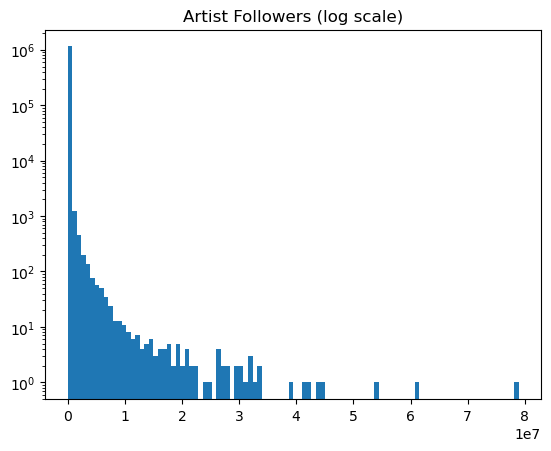

In [43]:
plt.hist(artists["followers"], bins=100)
plt.yscale("log")
plt.title("Artist Followers (log scale)")
plt.show()

Artist-level metrics, including popularity and follower counts, were reviewed as a sanity check to ensure extreme values were plausible. Highly followed, well-known artists appeared at the upper end of the distribution, while lesser-known artists with zero or low follower counts appeared at the lower end, consistent with real-world expectations. As a result, no values were capped or removed during this step.

##### Outliers in the Tracks Dataset
Track-level follow-up was limited to features with outlier prevalence above 1% in the IQR summary, so the detailed review focused on `instrumentalness`, `speechiness`, `liveness`, `duration_ms`, and `loudness`.

In [44]:
# Focus only on track columns already flagged by the IQR summary
track_flagged_cols = [
    "instrumentalness",
    "speechiness",
    "liveness",
    "duration_ms",
    "loudness"
]

# Quick percentile profile for flagged columns
tracks[track_flagged_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
instrumentalness,536579.0,0.098252,0.248963,0.0,0.0,0.0,0.00002,0.85,0.939,1.0
speechiness,536579.0,0.089519,0.146735,0.0216,0.0251,0.0274,0.0431,0.31,0.94,0.971
liveness,536579.0,0.210098,0.182854,0.00572,0.0375,0.0579,0.136,0.644,0.939,1.0
duration_ms,536579.0,234336.153769,122089.499109,16416.0,59323.14,112440.0,220093.0,382933.0,589005.94,5621218.0
loudness,536579.0,-9.917744,4.915383,-54.837,-25.59,-19.131,-8.965,-3.852,-2.508,5.376


In [45]:
# Review upper/lower tails for each flagged column
for col in track_flagged_cols:
    print(f"\n=== {col} | upper tail ===")
    display(
        tracks.sort_values(col, ascending=False).head(5)[
            ["track_name", "track_id", "release_date", "track_popularity", col]
        ]
    )

    print(f"=== {col} | lower tail ===")
    display(
        tracks.sort_values(col, ascending=True).head(5)[
            ["track_name", "track_id", "release_date", "track_popularity", col]
        ]
    )


=== instrumentalness | upper tail ===


,track_name,track_id,release_date,track_popularity,instrumentalness
391204,Sleep Baby Sleep - Loopable with No Fade,2uZ0qOubPeAoRU4qsmJ9Rx,2017-09-04,57,1.0
336784,Pink Noise - BP 280 hz res,17t5hM2gTIgbetpQnRrBox,2017-11-24,41,1.0
553128,睡眠噪音,1IgvJ2lY2PU0kQ72zz8BvY,2018-03-22,35,1.0
79302,Cours d'eau de montagne,3mjuGIYIdxALWUBj1zQDlJ,1974-04-20,13,1.0
484539,White Noise: Mindfulness Meditations (Loopable),0ob3ppET6D0NPv4kHF5cmu,2016-12-29,62,1.0


=== instrumentalness | lower tail ===


,track_name,track_id,release_date,track_popularity,instrumentalness
0,A la sombra de una mentira - Directo Luz Casal,41bB9f0ixLKhzYs4VuMWtE,1999-11-11,31,0.0
291282,My Name Is Not Susan,7623p8KZ24WTeO0NeIb4tV,1990-11-04,46,0.0
291290,"My Neck, My Back",04NMCxLqlXuyONlkdH4rY2,2002,54,0.0
291291,"My Neck, My Back",3H6JUtLbiZh07T7GLiuTON,2002,51,0.0
291292,"My Neck, My Back (Lick It)",4IIeMa34TTzdQky4yZUgD3,2020-06-09,1,0.0



=== speechiness | upper tail ===


,track_name,track_id,release_date,track_popularity,speechiness
480301,"Wer die Nachtigall stört ..., Kapitel 6",4dpSno2rYwlcdEtTzJxUjR,1960,8,0.971
480178,"Wer die Nachtigall stört ..., Kapitel 1",4ucGpd15TTUybXsoS5mH9Q,1960,12,0.971
480343,"Wer die Nachtigall stört ..., Kapitel 98",1nbEqHuviTXtjbh4jei86V,1960,6,0.971
215181,Kapitel 15 - Der alte Mann und das Meer - Erzä...,5c1iGqmxzXvDhiDYO1MU7Q,1952,10,0.970
215335,Kapitel 16 - Der alte Mann und das Meer - Erzä...,5nnUR41x2t9KvRDKumNcKC,1952,10,0.970


=== speechiness | lower tail ===


,track_name,track_id,release_date,track_popularity,speechiness
377940,Sei nell'anima,6shzlUkm7OcnoO4guEiGJ8,2006-11-27,54,0.0216
47783,Borrow,1IELihLEFMtJgLqCJchsbP,1998-01-01,41,0.0216
386788,Siempre Tu A Mi Lado,2nqtMyu04rLRl1Fb9GTqoi,2004-01-01,40,0.0218
249634,Livet Er Lykken,1MgdWJSkFZICdcMexl2BWb,1988-08-11,8,0.0218
51879,Bunga,2tggy9ynZ0IOFLrPsiSAsj,2012-01-01,45,0.0220



=== liveness | upper tail ===


,track_name,track_id,release_date,track_popularity,liveness
271239,Me Quedo Contigo (Si Me Das A Elegir) - Live B...,6u9GgwXbMs5jJlA29zGHu5,2009-09-14,59,1.000
263108,Make It Real - Live,5OnF6A4ldpgsDhkB7MqdbI,1985-06-20,25,1.000
135393,Final Caja Negra - Me Verás Volver Gira 2007,72G1Ywo0HKm4JaX1PSdQaw,2008-07-14,40,1.000
74851,Como Pájaros En El Aire - Live,0r6ZLb3EilxfAogZa99cuL,1996-01-01,42,1.000
390518,Skin Deep - Live,0k2cvPNBXi2dxDWmcQujYJ,1956,16,0.999


=== liveness | lower tail ===


,track_name,track_id,release_date,track_popularity,liveness
454967,Tumbakutun,1rxjCGtwxNRJksenGiJbCW,1976-01-01,20,0.00572
280956,Mirándote,61HBVoReWHVKEhG3xSWGCK,2008-09-09,43,0.00838
66564,Charlie Brown,6Q0aBakbTsjQO6iGdxmXlx,2005-12-20,53,0.00967
172470,Hors-la-loi,1fVZxmQ9PqxcbMqTUFIVHx,1985-12-10,21,0.00986
467043,Ven Michu Michu,4ybBsH2mE1F4zUceMObNF6,1992-01-01,22,0.00989



=== duration_ms | upper tail ===


,track_name,track_id,release_date,track_popularity,duration_ms
530984,โครงสร้างแห่งสิ่งที่เรียกว่าชีวิต,3EEv9UCeZdn4MVFv8tsO1E,1979-07-28,3,5621218
300210,New Year's Eve 2015 Party Hits - Full DJ Party...,6rGikpwOv3LXaHWVCYbMNC,2014-12-19,0,5042185
411631,Surah Al-Araf,7jTxNjSwPcPjSbK8829Vno,2010-01-01,39,4995083
423223,Tech House The Yearbook 2018 - Continuous Mix 2,7r86YmJo79FRcAHuVeKZp8,2018-12-16,0,4864333
411680,Surah An-Nisa,3PmwiLyD0yPI63SsglmPN5,2010-01-01,43,4797258


=== duration_ms | lower tail ===


,track_name,track_id,release_date,track_popularity,duration_ms
401869,Spring Song with Banjo,0qCLQ6gNLruIT9gwA39H6I,1952,0,16416
452410,Trump Wins (2016),3EO6mgn79vsEm2wKFSIiev,2018-01-12,0,17162
402380,"St. Matthew Passion, BWV 244 - Part One: No.9a...",0t5DO8Z16TgcIyCFkUflNn,1952-01-01,0,17533
196326,Introduction,2h3V6Hd3W9riO5woPyWLUk,2008-02-11,0,18467
108949,Dust of Snow,17aXSvwW1WughiCvxAyLGj,1951,0,19597



=== loudness | upper tail ===


,track_name,track_id,release_date,track_popularity,loudness
322674,Oublie,0yJuAlzqESb2Xl1N13QTxl,1963-02-17,4,5.376
262784,Maintenant Il Téléphone,2fIt4yVHryA7IahDOiVknA,1963-02-17,3,5.109
455997,Tut Tut Tut Tut,7iPCMs7se6gKCiKKA7Er1W,1963-02-17,36,4.584
297104,Ne T'en Fais Pas,05bMIC8vtBUbJL5ZdTINk8,1963-02-17,4,4.362
204009,Jean-Lou,6z1VZUCyun0i3qP5BYDl8l,1963-02-17,2,4.110


=== loudness | lower tail ===


,track_name,track_id,release_date,track_popularity,loudness
120615,Empty Field Noise,0sFnPQ0VLpZRXwSxjxFIyZ,2017-05-07,51,-54.837
478920,We Praise Thee,39HgNoEwV9xAJgLctTOtb5,1996-01-01,34,-48.488
398509,Sonic Contours,3Udn9STWY11Gwt1FrsQ1Ci,1957-01-01,17,-48.361
365688,Rouge gorge familier - Robin,3Di87379a9EzxLh21TyVRf,1991,23,-47.140
260306,"Ma mère l'oye, M. 60 (Version for Piano Duo): ...",3M7dYsUVdr66ztv5yXqOFm,1990-11-01,57,-47.046


Several track audio features showed skewed distributions, which is expected given the range of content types in the catalog. These tail patterns were treated as plausible signal rather than data errors, so no additional outlier capping or row removal was applied in this step.

### 3.3 Dataset Integration 
Some tracks in the dataset are associated with multiple artists, while artist-level information is stored separately. To preserve a one-track-per-row structure for modeling, the data is temporarily reshaped into a track-artist format, enriched with artist metadata, and then aggregated back to the track level. This produces a modeling dataset that keeps a 1:1 track-to-row structure while adding artist context features. The integration step also creates relative artist-popularity features at the track-artist level by comparing each artist’s popularity to peers in the same release year using a robust z-score (median/IQR) and a within-year percentile rank; these are then available for downstream track-level aggregation.

#### 3.3.1 Expanding Tracks into a Long Track-Artist Table
Some tracks are associated with multiple artists. In this step, the data is expanded so that each row represents a single track-artist relationship. This intermediate table allows artist-level information to be joined correctly while preserving a one-track-per-row structure after aggregation.

In [46]:
track_artist_long = (
    tracks[["track_id", "release_year", "artist_id_list"]]
    .explode("artist_id_list", ignore_index=True)
    .rename(columns={"artist_id_list": "artist_id"})
)

# Composite key 
track_artist_long["track_artist_id"] = (
    track_artist_long["track_id"].astype(str) + "_" +
    track_artist_long["artist_id"].astype(str)
)

#### 3.3.2 Adding Artist Information to the Long Track-Artist Table
Artist-level attributes such as popularity, follower counts, genres, and artist names are merged into the long track-artist table created in the previous step. At this stage, the number of genres per artist is computed for later track-level aggregation. Two relative popularity features are also created at the artist-row level: a release-year robust z-score of artist popularity (centered by year median and scaled by year IQR) and a within-year percentile rank. These features are later aggregated back to one row per track.

In [47]:
# merge tracks with artist information 
track_artist_long = track_artist_long.merge(
    artists[["artist_id","artist_name","genres", "artist_popularity", "followers"]],
    on="artist_id",
    how="left"
)
track_artist_long["n_genres"] = track_artist_long["genres"].apply(
    lambda g: len(g) if isinstance(g, list) else 0
)
track_artist_long.head()

,track_id,release_year,artist_id,track_artist_id,artist_name,genres,artist_popularity,followers,n_genres
0,41bB9f0ixLKhzYs4VuMWtE,1999,0P4FkbP57uc9XBnJ9aoA3N,41bB9f0ixLKhzYs4VuMWtE_0P4FkbP57uc9XBnJ9aoA3N,Rosendo,"[cantautor, rock en espanol, spanish new wave,...",53,193535.0,4
1,41bB9f0ixLKhzYs4VuMWtE,1999,1HUbv0v2f9HNE6qIbB35El,41bB9f0ixLKhzYs4VuMWtE_1HUbv0v2f9HNE6qIbB35El,Luz Casal,"[cantautor, spanish pop]",59,202530.0,2
2,6oaCiTjMBjXunayoTxDoIs,1977,3zVGMz661UQBxwt04UIYV0,6oaCiTjMBjXunayoTxDoIs_3zVGMz661UQBxwt04UIYV0,Lluis Llach,"[cantautor, cantautor catala, catalan folk, mu...",41,40865.0,6
3,0lstDvubsePLSuUiGWsNL8,2021,1QJbbsxg2wqidJj51d3otw,0lstDvubsePLSuUiGWsNL8_1QJbbsxg2wqidJj51d3otw,Natos y Waor,"[rap espanol, rap underground espanol, spanish...",71,554655.0,4
4,0lstDvubsePLSuUiGWsNL8,2021,4bWHA8fMNjzfGPQqnh5D6y,0lstDvubsePLSuUiGWsNL8_4bWHA8fMNjzfGPQqnh5D6y,Recycled J,"[rap espanol, urbano espanol]",67,140937.0,2


In [48]:
eps = 1e-9

year_stats = (
    track_artist_long.groupby("release_year")["artist_popularity"]
    .agg(
        year_median="median",
        q1=lambda s: s.quantile(0.25),
        q3=lambda s: s.quantile(0.75),
    )
    .reset_index()
)
year_stats["year_iqr"] = (year_stats["q3"] - year_stats["q1"]).clip(lower=eps)

track_artist_long = track_artist_long.merge(
    year_stats[["release_year", "year_median", "year_iqr"]],
    on="release_year",
    how="left"
)

track_artist_long["artist_popularity_vs_year_robust_z"] = (
    (track_artist_long["artist_popularity"] - track_artist_long["year_median"])
    / track_artist_long["year_iqr"]
)

# percentile rank within year (0..1)
track_artist_long["artist_popularity_vs_year_pct"] = (
    track_artist_long.groupby("release_year")["artist_popularity"]
    .rank(method="average", pct=True)
)
track_artist_long.head()

,track_id,release_year,artist_id,track_artist_id,artist_name,genres,artist_popularity,followers,n_genres,year_median,year_iqr,artist_popularity_vs_year_robust_z,artist_popularity_vs_year_pct
0,41bB9f0ixLKhzYs4VuMWtE,1999,0P4FkbP57uc9XBnJ9aoA3N,41bB9f0ixLKhzYs4VuMWtE_0P4FkbP57uc9XBnJ9aoA3N,Rosendo,"[cantautor, rock en espanol, spanish new wave,...",53,193535.0,4,51.0,25.0,0.08,0.550431
1,41bB9f0ixLKhzYs4VuMWtE,1999,1HUbv0v2f9HNE6qIbB35El,41bB9f0ixLKhzYs4VuMWtE_1HUbv0v2f9HNE6qIbB35El,Luz Casal,"[cantautor, spanish pop]",59,202530.0,2,51.0,25.0,0.32,0.656378
2,6oaCiTjMBjXunayoTxDoIs,1977,3zVGMz661UQBxwt04UIYV0,6oaCiTjMBjXunayoTxDoIs_3zVGMz661UQBxwt04UIYV0,Lluis Llach,"[cantautor, cantautor catala, catalan folk, mu...",41,40865.0,6,52.0,27.0,-0.407407,0.304373
3,0lstDvubsePLSuUiGWsNL8,2021,1QJbbsxg2wqidJj51d3otw,0lstDvubsePLSuUiGWsNL8_1QJbbsxg2wqidJj51d3otw,Natos y Waor,"[rap espanol, rap underground espanol, spanish...",71,554655.0,4,69.0,27.0,0.074074,0.549156
4,0lstDvubsePLSuUiGWsNL8,2021,4bWHA8fMNjzfGPQqnh5D6y,0lstDvubsePLSuUiGWsNL8_4bWHA8fMNjzfGPQqnh5D6y,Recycled J,"[rap espanol, urbano espanol]",67,140937.0,2,69.0,27.0,-0.074074,0.463683


#### 3.3.3 Creating Track-Level Artist Features
Artist-level information is then summarized back to the track level. This includes the number of artists on a track, aggregated artist popularity and follower metrics, year-relative popularity metrics (percentile and robust z-score), and aggregated artist genres.

In [49]:
def aggregate_genres(series):
    """
    series is a column of lists (one list per artist)
    returns a deduplicated list of genres for the track
    """
    genres = set()
    for g in series:
        if isinstance(g, (list, tuple, set, np.ndarray)):
            genres.update(list(g))
    return sorted(genres)


In [50]:
artist_agg = (
    track_artist_long
    .groupby("track_id", as_index=False)
    .agg(
        artist_popularity_mean=("artist_popularity", "mean"),
        artist_popularity_max=("artist_popularity", "max"),
        artist_popularity_vs_year_pct_mean=("artist_popularity_vs_year_pct", "mean"),
        artist_popularity_vs_year_pct_max=("artist_popularity_vs_year_pct", "max"),
        artist_popularity_vs_year_robust_z_mean=("artist_popularity_vs_year_robust_z", "mean"),
        artist_popularity_vs_year_robust_z_max=("artist_popularity_vs_year_robust_z", "max"),
        artist_followers_mean=("followers", "mean"),
        artist_followers_max=("followers", "max"),
        n_artists=("artist_id", "nunique"),
        artist_genres_mean=("n_genres", "mean"),
        artist_genres_max=("n_genres", "max"),
        artist_genres=("genres", aggregate_genres),
    )
)

In [51]:
artist_agg.head()

,track_id,artist_popularity_mean,artist_popularity_max,artist_popularity_vs_year_pct_mean,artist_popularity_vs_year_pct_max,artist_popularity_vs_year_robust_z_mean,artist_popularity_vs_year_robust_z_max,artist_followers_mean,artist_followers_max,n_artists,artist_genres_mean,artist_genres_max,artist_genres
0,000CSYu4rvd8cQ7JilfxhZ,48.0,48,0.400541,0.400541,-0.16,-0.16,30176.0,30176.0,1,2.0,2,"[country quebecois, rock quebecois]"
1,000DsoWJKHdaUmhgcnpr8j,38.0,38,0.262375,0.262375,-0.518519,-0.518519,8623.0,8623.0,1,1.0,1,[barnmusik]
2,000G1xMMuwxNHmwVsBdtj1,73.0,73,0.912999,0.912999,0.777778,0.777778,914213.0,914213.0,1,6.0,6,"[candy pop, new wave, new wave pop, permanent ..."
3,000KblXP5csWFFFsD6smOy,44.0,44,0.308976,0.308976,-0.333333,-0.333333,26380.0,26380.0,1,3.0,3,"[chamame, folclore salteno, folklore argentino]"
4,000Npgk5e2SgwGaIsN3ztv,36.0,36,0.459621,0.459621,-0.0625,-0.0625,310997.0,310997.0,1,5.0,5,"[classic bollywood, classic pakistani pop, fil..."


#### 3.3.4 Creating an Enriched Tracks Dataset
The aggregated artist features are joined to the original track data to form a new, enriched tracks dataset, while preserving the original tracks table for independent analysis.

In [52]:
tracks_enriched = tracks.merge(
    artist_agg,
    on="track_id",
    how="left"
)

tracks_enriched.head()

,track_name,duration_ms,explicit,artists,artist_id_list,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,track_id,track_popularity,track_name_key,artists_key,artist_popularity_mean,artist_popularity_max,artist_popularity_vs_year_pct_mean,artist_popularity_vs_year_pct_max,artist_popularity_vs_year_robust_z_mean,artist_popularity_vs_year_robust_z_max,artist_followers_mean,artist_followers_max,n_artists,artist_genres_mean,artist_genres_max,artist_genres
0,A la sombra de una mentira - Directo Luz Casal,237867,0,"[Rosendo, Luz Casal]","[0P4FkbP57uc9XBnJ9aoA3N, 1HUbv0v2f9HNE6qIbB35El]",1999-11-11,0.397,0.552,6,-5.165,1,0.0301,0.27800,0.000000,0.7760,0.072,119.443,3,1999,41bB9f0ixLKhzYs4VuMWtE,31,a la sombra de una mentira - directo luz casal,"(Rosendo, Luz Casal)",56.0,59,0.603404,0.656378,0.2,0.32,198032.5,202530.0,2,3.0,4,"[cantautor, rock en espanol, spanish new wave,..."
1,A la taverna del mar,246533,0,[Lluis Llach],[3zVGMz661UQBxwt04UIYV0],1977,0.443,0.311,9,-10.462,0,0.0460,0.94200,0.000000,0.1040,0.197,111.589,3,1977,6oaCiTjMBjXunayoTxDoIs,17,a la taverna del mar,"(Lluis Llach,)",41.0,41,0.304373,0.304373,-0.407407,-0.407407,40865.0,40865.0,1,6.0,6,"[cantautor, cantautor catala, catalan folk, mu..."
2,A la tumba,230640,1,"[Natos y Waor, Recycled J]","[1QJbbsxg2wqidJj51d3otw, 4bWHA8fMNjzfGPQqnh5D6y]",2021-04-13,0.652,0.643,1,-6.640,1,0.2740,0.17800,0.000006,0.1070,0.368,173.841,4,2021,0lstDvubsePLSuUiGWsNL8,39,a la tumba,"(Natos y Waor, Recycled J)",69.0,71,0.50642,0.549156,0.0,0.074074,347796.0,554655.0,2,3.0,4,"[rap espanol, rap underground espanol, spanish..."
3,"A la vie, à l'amour",294532,0,[Jakie Quartz],[5wGprTHwvhRJpnN4vWlLDT],1988-01-01,0.621,0.807,0,-10.399,0,0.0365,0.13400,0.019400,0.0621,0.948,124.792,4,1988,5IrrXLgh91DxJejyFS0HY9,21,"a la vie, à l'amour","(Jakie Quartz,)",29.0,29,0.115301,0.115301,-0.76,-0.76,5832.0,5832.0,1,1.0,1,[classic french pop]
4,A las Barricadas,95765,0,[Los Muertos de Cristo],[3kB55UDQKH1NV9TLKWgE8p],1994-11-11,0.366,0.836,4,-13.278,0,0.1520,0.00341,0.000052,0.0359,0.376,171.832,4,1994,2PEGaeKDYYGhbryvNStR7b,37,a las barricadas,"(Los Muertos de Cristo,)",41.0,41,0.316708,0.316708,-0.32,-0.32,41206.0,41206.0,1,1.0,1,[spanish punk]


### 3.4 Post-Integration Quality Filtering
After integration, additional quality checks are applied to the merged track-level dataset to ensure feature consistency before modeling. This section handles missing artist-derived aggregates, flags incomplete genre metadata, filters records with mismatched popularity/follower signals, and runs final sanity checks prior to export.

#### 3.4.1 Missing Artist Context Metadata
This step checks whether any merged track rows are missing required artist-derived aggregate features.

In [53]:
tracks_enriched.isna().mean().sort_values(ascending=False)

artist_popularity_vs_year_robust_z_mean    0.018508
artist_popularity_max                      0.018508
artist_followers_max                       0.018508
artist_followers_mean                      0.018508
artist_popularity_vs_year_robust_z_max     0.018508
artist_popularity_mean                     0.018508
artist_popularity_vs_year_pct_max          0.018508
artist_popularity_vs_year_pct_mean         0.018508
track_popularity                           0.000000
track_name_key                             0.000000
artists_key                                0.000000
track_name                                 0.000000
release_year                               0.000000
n_artists                                  0.000000
artist_genres_mean                         0.000000
artist_genres_max                          0.000000
track_id                                   0.000000
time_signature                             0.000000
duration_ms                                0.000000
key         

In [54]:
artist_agg_cols = [
    "artist_followers_mean",
    "artist_followers_max",
    "artist_popularity_mean",
    "artist_popularity_max",
    "artist_popularity_vs_year_robust_z_mean",
    "artist_popularity_vs_year_robust_z_max",     
    "artist_popularity_vs_year_pct_max",         
    "artist_popularity_vs_year_pct_mean"
]

tracks_enriched = tracks_enriched.dropna(subset=artist_agg_cols)

Rows missing required artist-derived aggregate features were removed because these variables are central to the enriched modeling design. Since the affected share was very small, this filtering improves feature completeness with minimal impact on overall dataset coverage.

#### 3.4.2 Genre Metadata Flag Creation
This step creates a binary indicator to capture whether aggregated artist genre metadata is present for each track.

In [55]:
col = "artist_genres"

is_empty_list = tracks_enriched[col].apply(lambda x: isinstance(x, list) and len(x) == 0)
empty_count = is_empty_list.sum()
total_rows = len(tracks_enriched)
empty_pct = empty_count / total_rows * 100

print("Empty lists:", empty_count)
print("Total rows:", total_rows)
print(f"Percent empty: {empty_pct:.2f}%")

Empty lists: 32018
Total rows: 526648
Percent empty: 6.08%


In [56]:
# Flag rows where aggregated artist genre metadata is available
tracks_enriched["has_genre_metadata"] = tracks_enriched["artist_genres"].apply(
    lambda x: int(isinstance(x, list) and len(x) > 0)
).astype("Int64")

In [57]:
tracks_enriched["has_genre_metadata"].value_counts(dropna=False)

has_genre_metadata
1    494630
0     32018
Name: count, dtype: Int64

The empty-rate for aggregated artist genres was 6.08%, which was large enough to retain rather than drop. To preserve this portion of the dataset while still capturing missing context, rows were kept and a binary `has_genre_metadata` flag was added for downstream modeling.

#### 3.4.3 Mismatch Rule Filtering
This step applies rule-based filters to identify records with inconsistent popularity and follower signals after artist-track aggregation.

In [58]:
# Use artist-table medians as consistency thresholds
before = len(tracks_enriched)
artist_pop_median = artists["artist_popularity"].median()
artist_followers_median = artists["followers"].median()

mismatch_mask = (
    # Case 1: zero followers but high popularity
    ((tracks_enriched["artist_followers_mean"] == 0) & (tracks_enriched["artist_popularity_mean"] >= artist_pop_median)) |
    ((tracks_enriched["artist_followers_max"] == 0) & (tracks_enriched["artist_popularity_max"] >= artist_pop_median)) |
    # Case 2: zero popularity but high followers
    ((tracks_enriched["artist_popularity_mean"] == 0) & (tracks_enriched["artist_followers_mean"] >= artist_followers_median)) |
    ((tracks_enriched["artist_popularity_max"] == 0) & (tracks_enriched["artist_followers_max"] >= artist_followers_median))
)

tracks_enriched = tracks_enriched.loc[~mismatch_mask].copy()

after = len(tracks_enriched)
print(f"Rows before: {before:,}")
print(f"Rows after : {after:,}")
print(f"Rows dropped total: {before - after:,}")

Rows before: 526,648
Rows after : 526,203
Rows dropped total: 445


Rule-based mismatch filtering removed rows with internally inconsistent artist signals, specifically cases where artist popularity and follower aggregates strongly contradicted each other. Because these checks rely only on artist-derived metadata and not the target variable, they help reduce likely metadata errors while preserving modeling integrity.

#### 3.4.4 Zero-Value Sanity Check
This final check audits key zero-value conditions in the enriched dataset to confirm that earlier filtering removed obvious placeholder or invalid patterns.

In [59]:
n = len(tracks_enriched)  
df_final = tracks_enriched.copy()

checks = {
    "tempo==0": (df_final["tempo"] == 0),
    "time_signature==0": (df_final["time_signature"] == 0),
    "duration_ms<=0": (df_final["duration_ms"] <= 0),
    "n_artists<=0": (df_final["n_artists"] <= 0),
    "artist_followers_mean==0": (df_final["artist_followers_mean"] == 0),
    "artist_followers_max==0": (df_final["artist_followers_max"] == 0),
    "artist_popularity_mean==0": (df_final["artist_popularity_mean"] == 0),
    "artist_popularity_max==0": (df_final["artist_popularity_max"] == 0),
    "has_genre_metadata==0": (df_final["has_genre_metadata"] == 0),
    "track_popularity==0": (df_final["track_popularity"] == 0),
}

summary = pd.DataFrame({
    "check": list(checks.keys()),
    "count": [int(m.sum()) for m in checks.values()],
})
summary["pct"] = (summary["count"] / n * 100).round(4)
display(summary.sort_values("count", ascending=False))

# Suspicious combination of zeros
suspicious_pattern = (
    (df_final["tempo"] == 0) &
    (df_final["danceability"] == 0) &
    (df_final["speechiness"] == 0) &
    (df_final["valence"] == 0)
)
print("Suspicious zero-audio pattern rows:", int(suspicious_pattern.sum()))

if suspicious_pattern.any():
    display(
        df_final.loc[suspicious_pattern, [
            "track_name","track_id","release_date","release_year",
            "track_popularity","tempo","danceability","speechiness","valence"
        ]].head(30)
    )

,check,count,pct
8,has_genre_metadata==0,31657,6.0161
9,track_popularity==0,11901,2.2617
6,artist_popularity_mean==0,1106,0.2102
7,artist_popularity_max==0,1106,0.2102
4,artist_followers_mean==0,98,0.0186
5,artist_followers_max==0,98,0.0186
0,tempo==0,0,0.0000
1,time_signature==0,0,0.0000
2,duration_ms<=0,0,0.0000
3,n_artists<=0,0,0.0000


Suspicious zero-audio pattern rows: 0


The zero-value sanity check showed no invalid structural cases: `tempo==0`, `time_signature==0`, `duration_ms<=0`, and `n_artists<=0` were all zero. No rows matched the suspicious zero-audio placeholder pattern. Remaining zeros were limited and interpretable, with most concentrated in `has_genre_metadata==0` and only small shares in zero popularity or follower-derived metrics, so no additional filtering was applied.

### 3.5 Final Modeling Dataset Export
With integration and post-merge quality checks complete, this section finalizes the modeling dataset and exports it for downstream analysis. It confirms that required features are present in the final table and writes the cleaned enriched dataset to disk in parquet format.

In [60]:
output_path = "tracks_enriched_model.parquet"
tracks_enriched_model = tracks_enriched.copy()
tracks_enriched_model.to_parquet(output_path, index=False)

print(f"Enriched dataset successfully saved to '{output_path}'.")
print(f"Final shape: {tracks_enriched_model.shape}")

Enriched dataset successfully saved to 'tracks_enriched_model.parquet'.
Final shape: (526203, 36)


The final modeling dataset contains 526,203 rows and 36 columns, down from the original 586,672 rows and 20 columns in the raw tracks table. This reflects the impact of integration and targeted quality filtering, while adding artist-derived context features for downstream modeling.

## 4. Data Preparation Summary and Key Takeaways
**Summary**

This notebook focused on cleaning and preparing Spotify track and artist data for analysis. The raw data included track-level audio features, artist metadata, and list-like fields such as artist IDs and genres. To integrate artist context while preserving a one-track-per-row structure, tracks were expanded into a long track-artist format, enriched with artist information, and then aggregated back to the track level. Post-integration quality filtering was then applied to address missing artist-context fields, flag missing genre metadata, and remove inconsistent artist popularity/follower signal patterns using artist-derived features. The final dataset includes audio features, summarized artist and genre attributes, year-relative artist popularity features, and a genre metadata indicator.


**Key Takeaways**
* Track and artist data exist at different levels and required reshaping to be combined correctly.
* Tracks with multiple artists were handled by expanding to a track-artist format and then aggregating artist features back to one row per track.
* List-like fields were normalized to avoid issues during merging and aggregation.
* Duplicate handling was performed in multiple passes, including exact and near-duplicate checks, before consolidation.
* `release_year` was used instead of full dates to avoid adding false precision.
* Relative popularity features were created at the artist-row level using year-based robust z-scores and within-year percentile ranks, then aggregated to track level.
* Empty aggregated genre lists were retained and flagged using `has_genre_metadata` rather than dropped.
* Additional post-merge rule-based and zero-value sanity checks were applied to improve consistency.
* The final modeling dataset has shape (526203, 36), reduced from the original tracks shape (586672, 20), and is ready for downstream EDA and modeling.